In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import random
from CombinationFunctions import ImageInputToDiT, NDiTModule, Decoder, TimeEmbedding, TextEmbedding


In [2]:

if(torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device: ", device)


Device:  cpu


In [3]:
class FinalModel(nn.Module):
    def __init__(self, latentSize, latentChannel, embedDimension, patchSize, T, numHeads, blocks, dropout, beta_schedule = "squaredcos_cap_v2", modelName="mit-han-lab/dc-ae-f64c128-in-1.0-diffusers"):
        super().__init__()

        self.input = ImageInputToDiT(latentSize, latentChannel, embedDimension, patchSize, T, beta_schedule, modelName)

        self.timeEmbedding = TimeEmbedding(embedDimension)
        self.textEmbeding = TextEmbedding()

        self.ditBlocks = NDiTModule(blocks, embedDimension, numHeads, dropout)
        
        self.output = Decoder(embedDimension, latentSize, latentChannel, patchSize, T, beta_schedule, modelName)

    def forward(self, x, captions, t):

        batchSize, channels, height, width = x.shape
        noisedLatents, noise = self.input(x, t)

        timeEmbed = self.timeEmbedding(t)
        textembed = self.textEmbeding(captions)

        ditOutput = self.ditBlocks(noisedLatents, textembed, timeEmbed)
        
        predictedNoise = self.output(ditOutput)
        
        return predictedNoise, noise


In [4]:
IMAGEHEIGHT = 512
IMAGEWIDTH = 512
EMBEDDINGDIM = 768
BATCHSIZE = 16
INCHANNELS = 3
LATENTSIZE = 8
LATENTCHANNEL = 128
PATCHSIZE = 2
T = 1000
DITBLOCK = 12
HEADS = 12
dropout = 0.2

epochs = 1000


model = FinalModel(latentSize=LATENTSIZE, latentChannel=LATENTCHANNEL, embedDimension=EMBEDDINGDIM, patchSize=PATCHSIZE,
                    T = T, numHeads=HEADS, blocks=DITBLOCK, dropout=dropout,
                    beta_schedule = "squaredcos_cap_v2", modelName = "mit-han-lab/dc-ae-f64c128-in-1.0-diffusers")

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),                 
    transforms.Normalize([0.5]*3, [0.5]*3)])

# model = torch.nn.DataParallel(model)
# model.to(device)




lossFn =  nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-5, weight_decay=3e-2, eps=1e-10)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
checkpoint_path = os.path.join("models", "dit_E4.pt")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    # print(f"Resuming from epoch {start_epoch}")
else:
    print("Loading pretrained model...")



In [6]:
image = torch.randn(3, 512, 512)
to_pil = transforms.ToPILImage()
imagePIL = to_pil(image)
imagePIL = transform(imagePIL).unsqueeze(0)
caption = ["A dog is running towards me"]
t = torch.Tensor([999]).long()

In [7]:
modelName = "mit-han-lab/dc-ae-f64c128-in-1.0-diffusers"
beta_schedule = "squaredcos_cap_v2"
noisyLatent = torch.randn(1, 128, 8, 8)

for t in reversed(range(1000)):

    tBatch = torch.Tensor([t]).long()
    predictedNoise, actualNoise = model(imagePIL, caption, tBatch)

    with torch.no_grad():
        latents = model.input.dc_ae.encode(imagePIL).latent

    alphaT = model.input.noiseScheduler.alphas_cumprod.to(device)[tBatch].view(1, 1, 1, 1)
    noisyLatents = torch.sqrt(alphaT) * latents + torch.sqrt(1 - alphaT) * actualNoise
    originallatents = (noisyLatents - torch.sqrt(1 - alphaT) * predictedNoise) / torch.sqrt(alphaT)
    
    if(t > 0):
        betaT = model.input.noiseScheduler.betas[tBatch]
        mean = torch.sqrt(model.input.noiseScheduler.alphas_cumprod[t-1]) * originallatents + \
            torch.sqrt(1 - model.input.noiseScheduler.alphas_cumprod[t-1]) * predictedNoise
        noise = torch.randn_like(originallatents)
        nextStepLatents = mean + torch.sqrt(betaT) * noise
        with torch.no_grad():
            originalImage = model.input.dc_ae.decode(nextStepLatents).sample
            imagePIL = originalImage
        # print(originalImage.shape)
        # break
    else:
        with torch.no_grad():
            originalImage = model.input.dc_ae.decode(originallatents).sample
            imagePIL = originalImage
        imagePIL = imagePIL * 0.5 + 0.5
        break
    if t % 50 == 0:
        print(f" {t} order Completed ")


originalImage = imagePIL.squeeze(0)
image = to_pil(originalImage)
plt.imshow(image)
plt.axis('off')

 950 order Completed 
 900 order Completed 
 850 order Completed 


KeyboardInterrupt: 

In [ ]:
image.save("output.png")

In [ ]:



with torch.no_grad():
    noisyLatents = dc_ae.encode(imagePIL).latent

alphaT = noiseScheduler.alphas_cumprod[t].view(1, 1, 1, 1)
originallatents = (noisyLatents - torch.sqrt(1 - alphaT) * predictedNoise) / torch.sqrt(alphaT)
originalImage = dc_ae.decode(originallatents).sample
# originalImage = originalImage * 0.5 + 0.5
originalImage = originalImage.squeeze(0)
originalImage.shape
image = to_pil(originalImage)

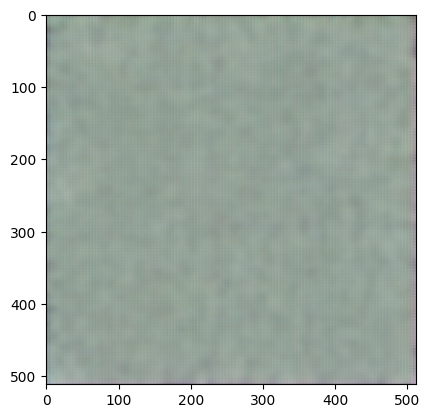

In [44]:
plt.imshow(image)